In [1]:
#!conda install -y gdown
#!gdown https://drive.google.com/uc?id=1XCkKX2e0cg6k2Nn868Obrat6GBXnjFJl
#!unzip -oq /kaggle/working/CCAI_CameraTrap.zip
#pip install -U imbalanced-learn

# Introduction to Deep Learning - Final Project
## Wildlife Camera Trap Classification

**Github link** https://github.com/conditas/deep_learning_final

Since 1970 there has been a drastic reduction in biodiversity averaging a 68% decrease in vertebrate wildlife populations across the world. Much of this is due to loss of habitation either from deforestation, war, or climate change. To learn more about animal populations, the causes of their declines and to potentially change the trajectory, a massive initiative has been undertaken to collect and track animals via camera traps. These camera traps are a low resource technology used to collect images of wildlife. They are battery operated, attached to trees and a motion sensor camera takes pictures whenever triggered. These camera traps have been deployed over several national parks in African countries. Some examples are Snapshot Serengeti, WildCam Gorongosa, and Wildwatch Kenya. 

A downside of this solution has been the large amount of human labor needed to examine and identify animals. Researchers rely on experts as well as online surveys to classify the millions of images recorded. 

The advancement of deep learning algorithms such as the convolutional neural networks learned in our course have made massive image classifying tasks like this more rapidly achievable. These images lend themselves well in this application because the background in the images are very similar partly due to the stationary nature of the camera. The animals have distinct patterns and shapes that can be detected through CNNs. One group, Miao et al., used a CNN with gradient-weighted class-activation-mapping and achieved an accuracy of 87.5% on data from the Gorongosa National Park. Another project by this same group used Vanilla Pytorch and Pytorch Lightining on a subset of data from Snapshot Kgalagadi representing six animal species. The models in this project obtained an average of about 60% accuracy.

In this project I will explore a dataset from the Kgalagadi Transfrontier Park. The preserve is a wildlife conservation park that spans the borders of Botswana, Nambia, and South Africa and is located in the Kalahiri. Research in this area is of importance in order to understand animal dynamics and patterns in extreme environmental conditions. I will create image classification models using CNNs, perform hyperparameter tuning and use accuracy as a performance metric for comparison. 

![](https://adventuretraveller.co.nz/wp-content/uploads/2018/06/kgalagadi-park-780x405.jpg)

Source: Adventure Traveller.co.nz
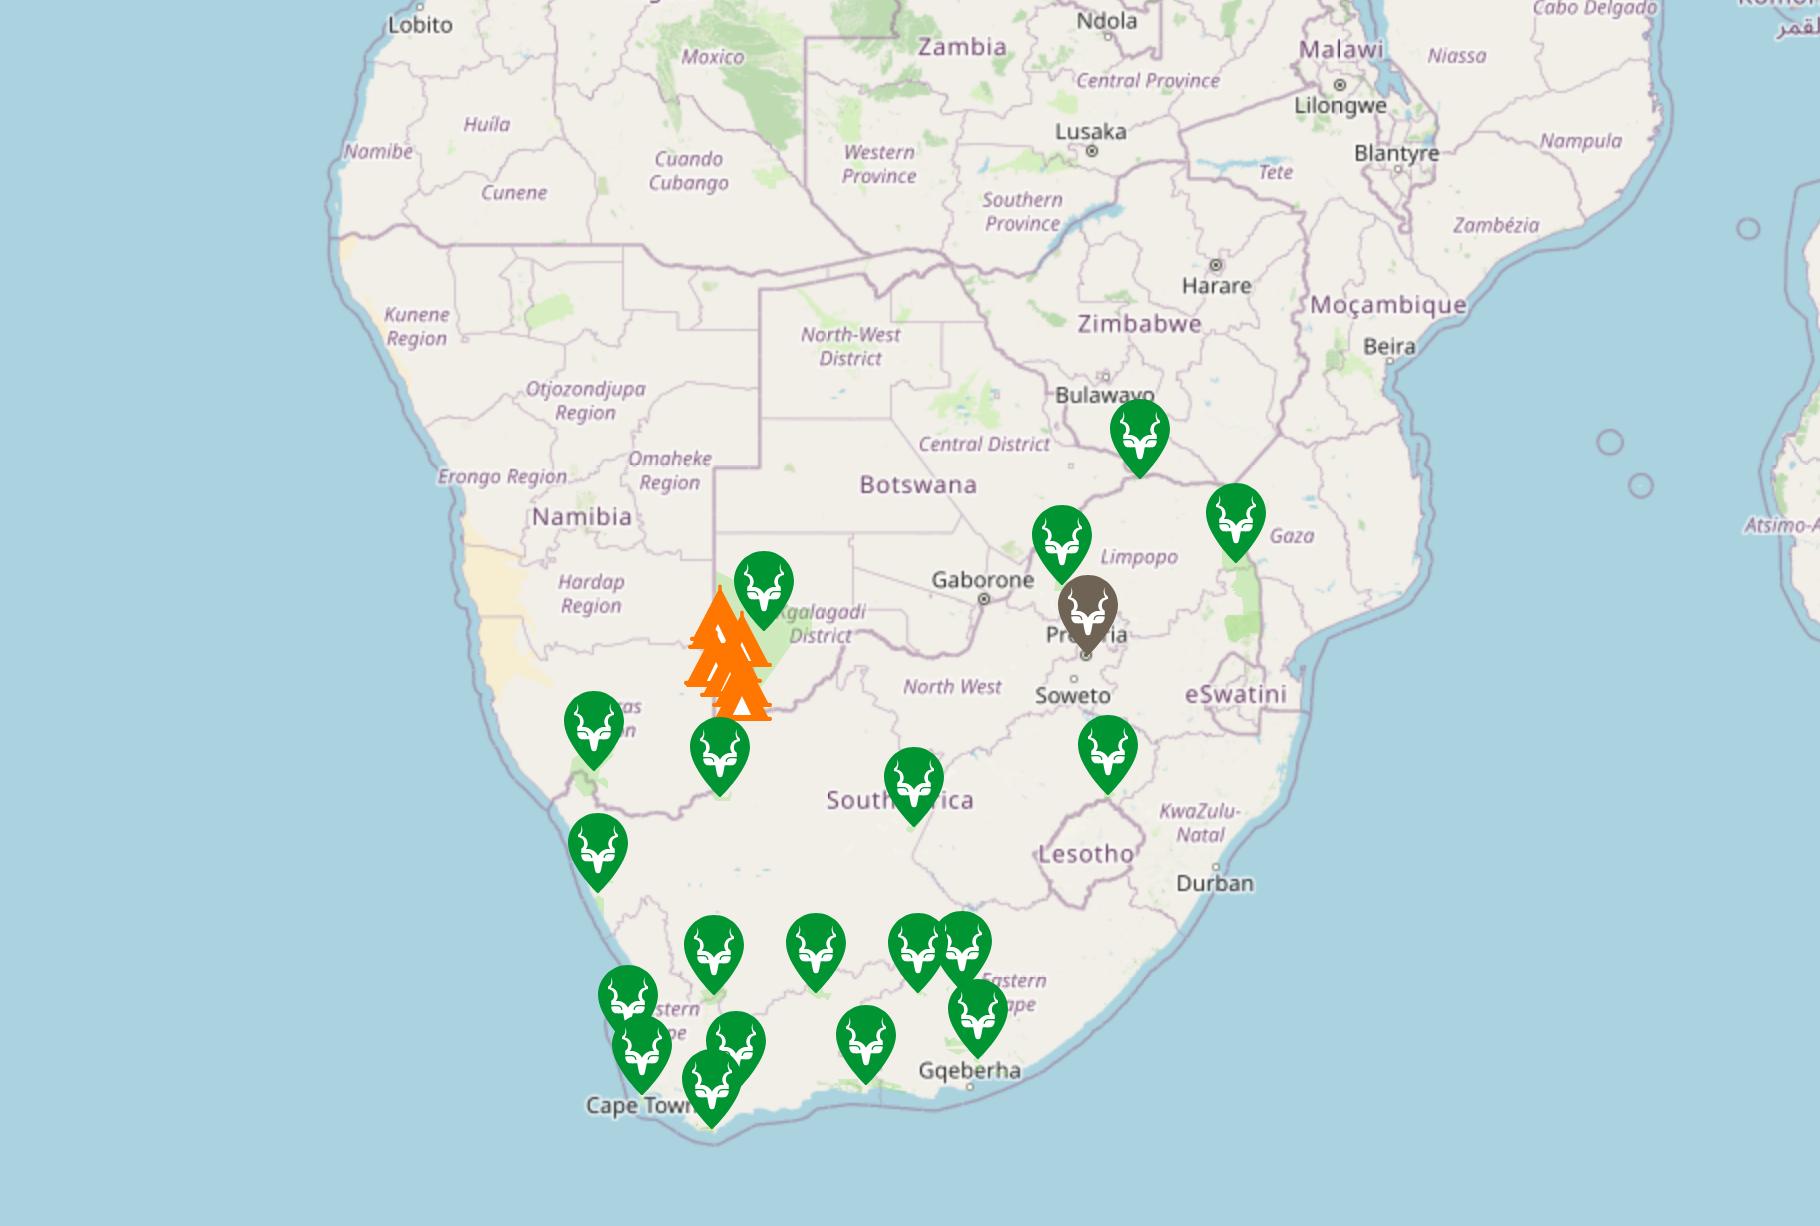

## Import Libraries

The following libraries will be used in my project.

In [2]:
from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy as sp
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow_datasets as tfds
#from tensorflow_examples.models.pix2pix import pix2pix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import time
from IPython.display import clear_output
import re

import PIL
from PIL import Image
import shutil
import json

import cv2
import gc
import os
import glob
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn import under_sampling, over_sampling
#from imblearn.over_sampling import SMOTE

import random

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE


## Data Description

The data that I used for this project comes from the LILA (Labeled Information Library of Alexandria: Biology and Conservation) site. I chose to use data from the Snapshot Kgalagadi project which is a subset of Snapshot Safari. It consists of a series of folders with 10222 camera trap images. These were separated out by site and roll number. These images were .JPGs and were 2000x2592 pixels and 3 RGB channel. There was a KGA_S1_report_lila.csv file that had annotations and the a total of 23 features (printed out below). The ones from this file that I will use are:

|Variable |	Description|
|:---------|:-------------|
|capute_id 	|Image ID |
|season |	Season|
|site |	Site Location|
|roll # |	Roll Number|
|capture |	Image Number per Site|
|question__species |	Label for item in picture|

There was also a .csv file (KGA_S1_report_lila_image_inventory.csv) that maps the capture_id to the image path in the folder. It's features are:
|Variable |	Description|
|:---------|:-------------|
|capute_id 	|Image ID |
|image_rank_in_capture |	Ranking of the image in the sequence|
|image_path |	Path to the image in the folders|



**Data Citation** Lion, M. (2019, December 29). Snapshot Kgalagadi. LILA BC. https://lila.science/datasets/snapshot-kgalagadi

**## Exploratory Data Analysis

The images in the folders are based on sequences where multiple images were captured of the same triggered event. The number of unique events was 3626. 

A significant proportion of the capture_id's were labeled as blank, wind or movement of vegetation could have triggered the camera sensor. I filtered out these and any that were labeled as human or vehicle for our modeling dataset. After filtering, the dataset was reduced drastically. I plotted a histogram of the animal distributions. In the histogram it is very obvious the data is imbalanced. This makes sense because in nature, certain animal species are going to have higher populations. 

I tried a few different approaches to solve the imbalance problem in my modeling:

- Using a Logit Loss function on a Baseline model
- Oversampling the minority class using Random Over Sample  from imblearn
- Undersampling the majority class using Random Under Sample also from imblearn

Below I load and filter the datasets, print summary information and plot distributions. I split the datasets up into training and validation sets with an 80/20 split. I created these sets for a baseline model, an oversampled model and an undersampled model. 

Number of Distinct Image Annotations:  3626
Features (columns):  Index(['capture_id', 'season', 'site', 'roll', 'capture', 'capture_date_local',
       'capture_time_local', 'subject_id', 'question__species',
       'question__count_max', 'question__count_median', 'question__count_min',
       'question__standing', 'question__resting', 'question__moving',
       'question__eating', 'question__interacting', 'question__young_present',
       'question__horns_count_max', 'question__horns_count_median',
       'question__horns_count_min', 'p_users_identified_this_species',
       'pielous_evenness_index'],
      dtype='object')
Image Size:  (2000, 2592, 3)




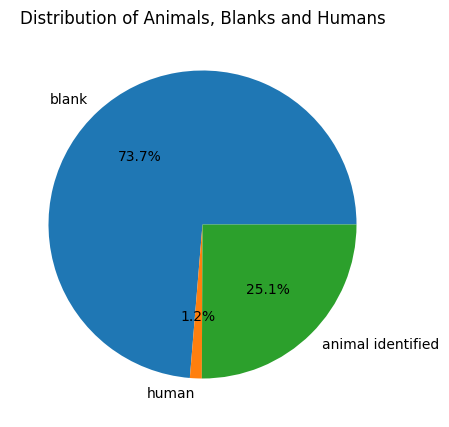

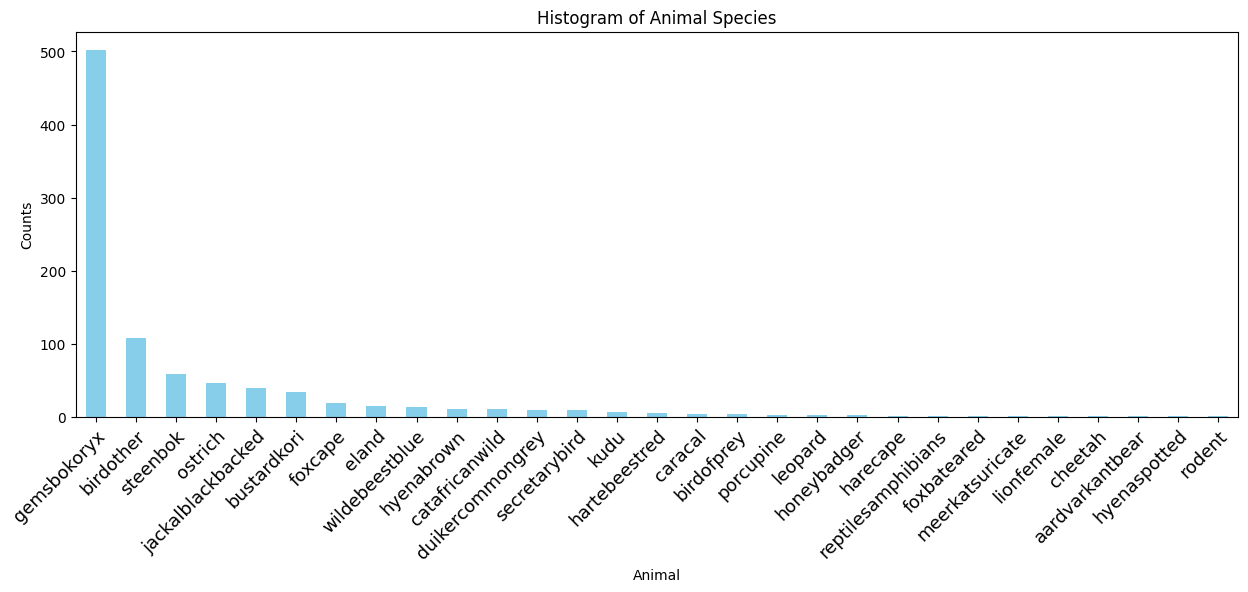

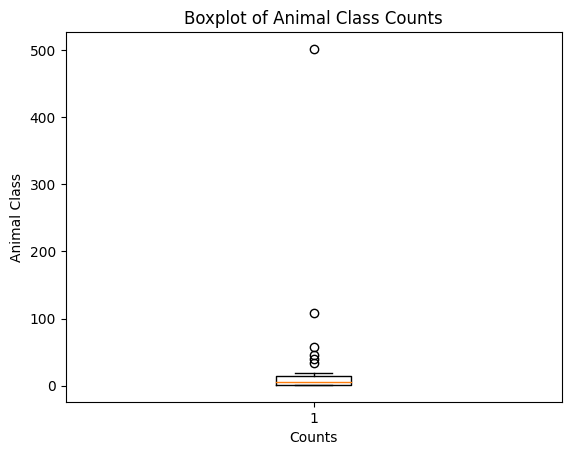

question__species
gemsbokoryx           502
birdother             108
steenbok               58
ostrich                46
jackalblackbacked      39
bustardkori            34
foxcape                19
eland                  14
wildebeestblue         13
hyenabrown             11
catafricanwild         10
duikercommongrey        9
secretarybird           9
kudu                    6
hartebeestred           5
caracal                 4
birdofprey              4
porcupine               3
leopard                 3
honeybadger             3
harecape                1
reptilesamphibians      1
foxbateared             1
meerkatsuricate         1
lionfemale              1
cheetah                 1
aardvarkantbear         1
hyenaspotted            1
rodent                  1
Name: count, dtype: int64


In [3]:
###################
# Using Lila Kgalagadi dataset
##################
# Load .csv file with animal annotations
###################

df_anno = pd.read_csv('/kaggle/input/kgalagadicsv-2/KGA_S1_report_lila.csv')
print("Number of Distinct Image Annotations: ",len(df_anno))
print("Features (columns): ",df_anno.columns)
df_anno.head(5)

example_path = '/kaggle/input/snapshot-kgalagadi/KGA_S1/A01/A01_R1/KGA_S1_A01_R1_IMAG0007.JPG'

img = np.array(Image.open(example_path))
print("Image Size: ", img.shape)               
print('\n')
# filter for only animals
filtered_df_anno = df_anno[df_anno['question__species'] != "blank"]
blanks = len(df_anno)-len(filtered_df_anno)
new_len = len(filtered_df_anno)
filtered_df_anno = filtered_df_anno[filtered_df_anno['question__species'] != "human"]
human = new_len - len(filtered_df_anno)
data = [blanks, human, len(filtered_df_anno)]

# create pi chart plot
fig = plt.figure(figsize=(5, 5))
plt.title('Distribution of Animals, Blanks and Humans')
plt.pie(data, labels=['blank', 'human',  'animal identified'], autopct='%1.1f%%')
plt.show()


# creating Data Frame of most important features
new_df = filtered_df_anno[['capture_id', 'season', 'site','roll','capture','question__species']].copy()


# create histogram of labels
fig = plt.figure(figsize = (15, 5))

new_df['question__species'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Animal')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=13)
plt.ylabel('Counts')
plt.title('Histogram of Animal Species')


# Display the histogram
plt.show()


# create the boxplot
plt.boxplot(new_df['question__species'].value_counts(), vert=True) 

plt.xlabel('Counts')
plt.ylabel('Animal Class')
plt.title('Boxplot of Animal Class Counts')


# Show the plot
plt.show()

print(new_df['question__species'].value_counts())

In [4]:
# Loading caputre_id to image path mapping .csv
image_map =pd.read_csv('/kaggle/input/kgalagadicsv-2/KGA_S1_report_lila_image_inventory.csv')
image_map.head()

capture_id  image_rank_in_capture  \
0  KGA_S1#A01#1#1                      1   
1  KGA_S1#A01#1#1                      2   
2  KGA_S1#A01#1#1                      3   
3  KGA_S1#A01#1#2                      1   
4  KGA_S1#A01#1#2                      2   

                                 image_path_rel  
0  KGA_S1/A01/A01_R1/KGA_S1_A01_R1_IMAG0001.JPG  
1  KGA_S1/A01/A01_R1/KGA_S1_A01_R1_IMAG0002.JPG  
2  KGA_S1/A01/A01_R1/KGA_S1_A01_R1_IMAG0003.JPG  
3  KGA_S1/A01/A01_R1/KGA_S1_A01_R1_IMAG0004.JPG  
4  KGA_S1/A01/A01_R1/KGA_S1_A01_R1_IMAG0005.JPG

In [5]:
################
# This section creates a data frame of the image paths and the labels associated with the image
##############

filenames = []
labels = []

train_path = '/kaggle/input/snapshotkagalagadi/KGA_S1'

for i,r in new_df.iterrows():
    capture_id = r['capture_id']
    image_path_rel = list(image_map['image_path_rel'][image_map['capture_id'] == capture_id])
    filenames.append(image_path_rel)
    labels.append(r['question__species'])


df = pd.DataFrame({'file': list(filenames), 'label': labels})
df.shape

print("Number of Different Animals in Images:", df.label.nunique())

#df.label.unique().tolist()

Number of Different Animals in Images: 29


Printing Example Pictures and Labels


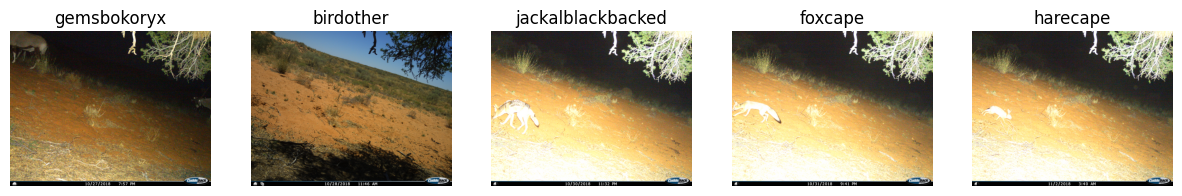

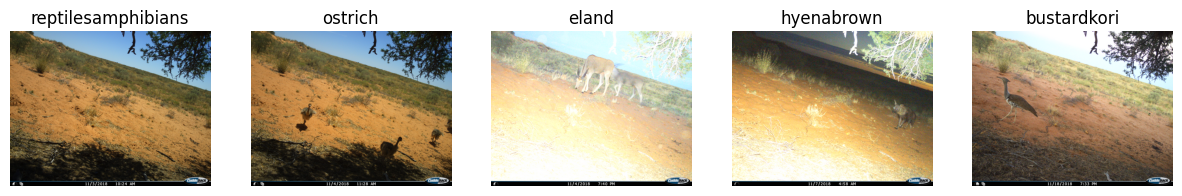

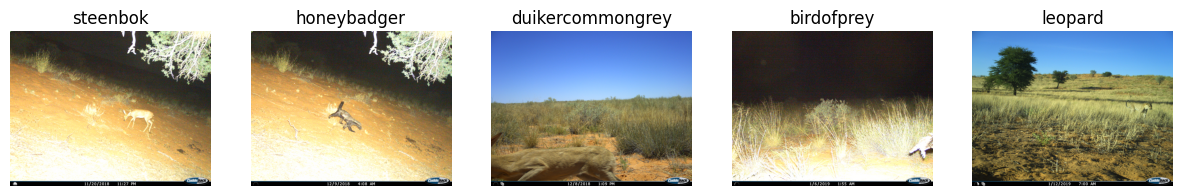

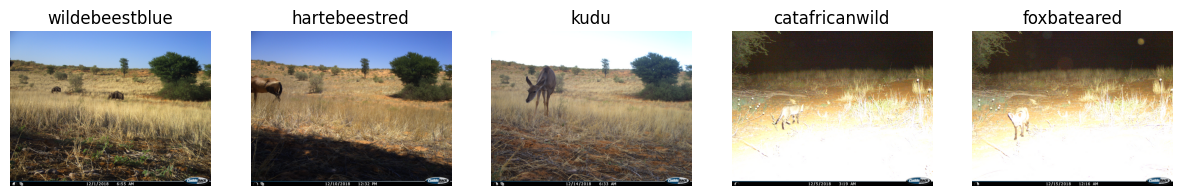

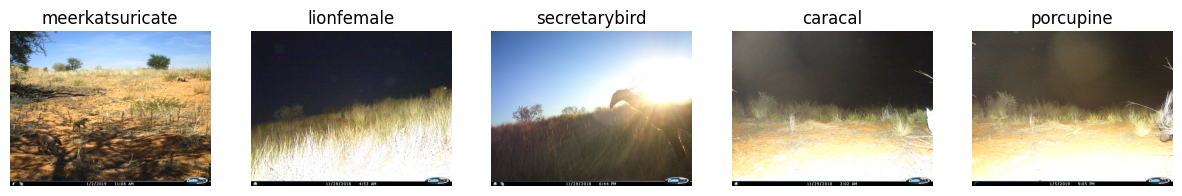

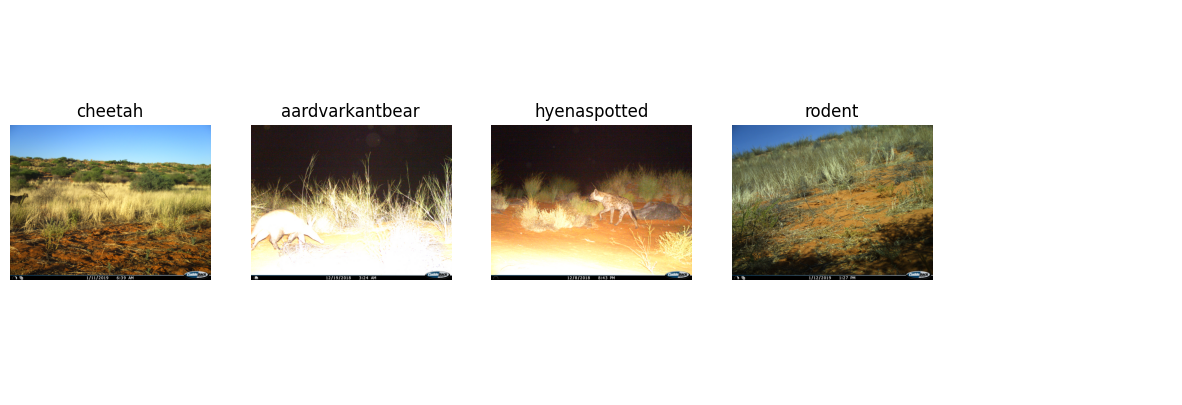

In [6]:
####################
### This section prints examples of the different animals to classify
###################
print("Printing Example Pictures and Labels")
#df.label.value_counts()
unique_animals = df.label.unique().tolist()
train_path = '/kaggle/input/snapshot-kgalagadi'
k=0

for i in range(6):
    fig, ax = plt.subplots(1, 5, figsize=(15, 5))
        
    for j in range(5): 
        if k < 29:
            filtered_df = df[df['label'] == unique_animals[k]]
            file_path = next(iter(filtered_df['file']))
            file_path = '/'.join([train_path, file_path[0]])
    
            img = np.array(Image.open(file_path))
            ax[j].set_title(unique_animals[k])
            ax[j].imshow(img)    
            ax[j].axis('off')
            k=k+1
        if k == 29:
            ax[j].axis('off')
    
    plt.show()

In [7]:
#############
# Create datasets for the model as np arrays
#############

x = []
y = []

df_list =  df['file']

# target value label classifier
y = df['label']

#here I open and store pixel info per image in array
train_path = '/kaggle/input/snapshot-kgalagadi'

with strategy.scope(): 
    for i in df_list:
        file_path = '/'.join([train_path, i[0]])
        img = cv2.imread(file_path)
        img = cv2.resize(img,(0, 0), fx = 0.1, fy = 0.1)


        img = (tf.cast(img, tf.float32) / 129.5) - 1
        #img = tf.reshape(img, [*IMG_SIZE, 3])

        
        x.append(img)
    x = np.array(x)  
    
y = np.array(y)
  
#use to predict probablity of being in class
encoded_y = pd.get_dummies(y).values
#print(x[0])

############
# Splitting into test and train
##############

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(x, encoded_y,
                                                  test_size = 0.2,
                                                  random_state = 1234)
print(X_train_baseline.shape, y_train_baseline.shape)

(727, 200, 259, 3) (727, 29)


### Oversampling

The code below creates a more evenly distributed dataset by randomly oversampling the minority cases. Initially this produced a dataset to big to easily work with. I went back and resampled this new oversampled dataset to make it a smaller size.  

In [8]:
###############
#### OVERSAMPLING
###############

y_over = df['label'].to_numpy()
x_over = df['file'].to_numpy()
ros = RandomOverSampler(random_state=42,sampling_strategy= 'not majority')

X_res_over, y_res_over = ros.fit_resample(x_over.reshape(-1, 1), y_over)
indices = random.sample(range(0,len(X_res_over)),2000)

X_oversampled = [X_res_over[i] for i in indices]
y_oversampled = [y_res_over[i] for i in indices]

In [9]:
###############
##OVERSAMPLED Dataset
############

#############
# Create image pixel datasets for the model as np arrays
#############
df_list =  X_oversampled
x_oversampled = []

#here I open and store pixel info per image in array
train_path = '/kaggle/input/snapshot-kgalagadi'

with strategy.scope(): 
    for i in df_list:        
        file_path = '/'.join([train_path, i[0][0]])
        img = cv2.imread(file_path)
        #resizing and scaling images
        img = cv2.resize(img,(0, 0), fx = 0.1, fy = 0.1)
        img = (tf.cast(img, tf.float32) / 129.5) - 1
        #img = tf.reshape(img, [*IMG_SIZE, 3])      
        x_oversampled.append(img)
    
    x_oversampled = np.array(x_oversampled)  
    
y_oversampled = np.array(y_oversampled)

#use to predict probablity of being in species class
encoded_y_oversampled = pd.get_dummies(y_oversampled).values


##### #######
# Splitting into test and train
##############

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(x_oversampled, 
                                                  encoded_y_oversampled,
                                                  test_size = 0.2,
                                                  random_state = 1234)
print("Oversampled train size x/y: ", X_train_over.shape, y_train_over.shape)

Oversampled train size x/y:  (1600, 200, 259, 3) (1600, 29)


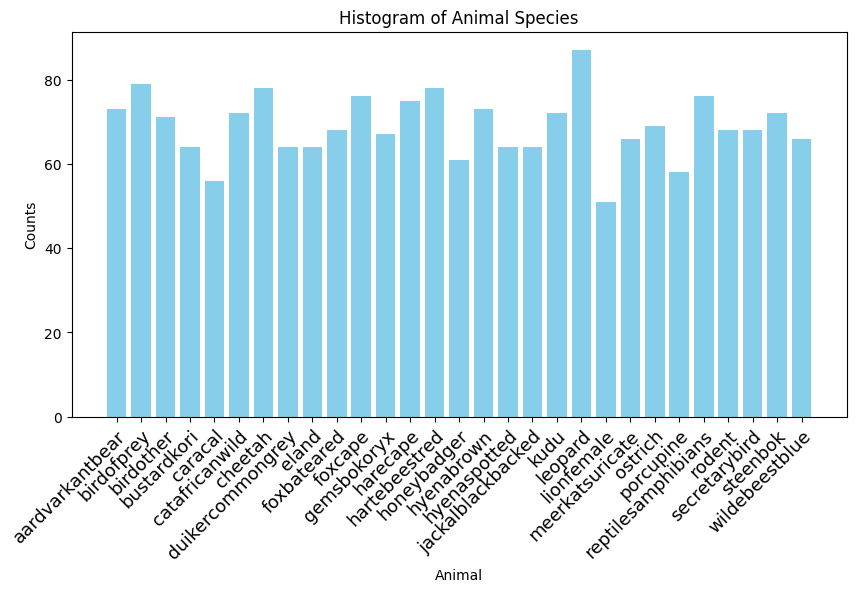

Oversampled Size:  2000


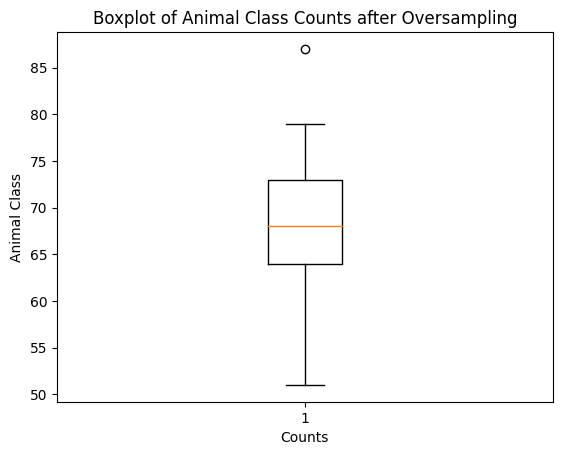

In [10]:
# Plotting histogram of new distribution
fig = plt.figure(figsize = (10, 5))

counts = np.unique(y_oversampled, return_counts=True)

plt.bar(counts[0],counts[1], color='skyblue')
plt.xlabel('Animal')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=13)
plt.ylabel('Counts')
plt.title('Histogram of Animal Species')

# Display the histogram
plt.show()
print("Oversampled Size: ", len(y_oversampled))

#create the boxplot
unique = np.unique(y_oversampled, return_counts=True)[1]
#print(unique)
plt.boxplot(unique, vert=True) 

plt.xlabel('Counts')
plt.ylabel('Animal Class')
plt.title('Boxplot of Animal Class Counts after Oversampling')

plt.show()

### Undersampling

The code below creates a more evenly distributed dataset by randomly undersampling the majority cases. 

Undersampled Size:  408


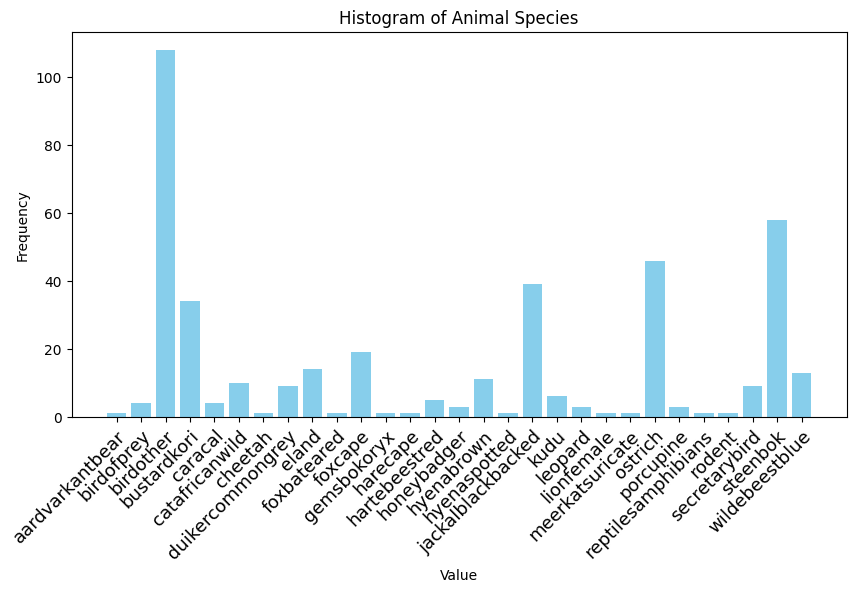

Undersampled train size x/y:  (326, 200, 259, 3) (326, 29)


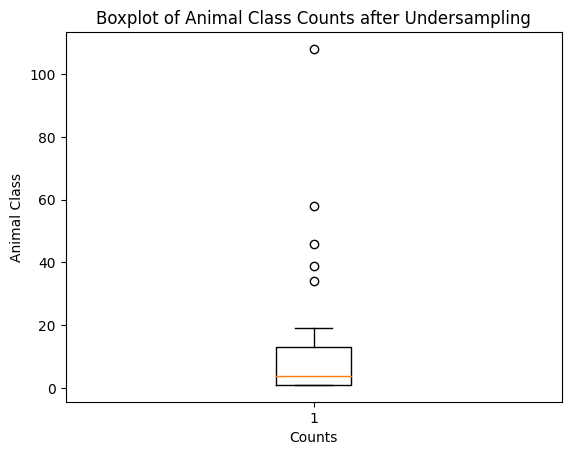

In [11]:
#########
#### Undersampling
#########

y_under = df['label'].to_numpy()
x_under = df['file'].to_numpy()

ros = RandomUnderSampler(random_state=42,sampling_strategy= 'majority')

X_res_under, y_res_under = ros.fit_resample(x_under.reshape(-1, 1), y_under)
print("Undersampled Size: ",len(X_res_under))

x_under = []
y_under = []

df_list =  X_res_under

# target value label classifier
y_under = y_res_under

#here I open and store pixel info per image in array
train_path = '/kaggle/input/snapshot-kgalagadi'

with strategy.scope(): 
    for i in df_list:
        
        file_path = '/'.join([train_path, i[0][0]])
        img = cv2.imread(file_path)
        img = cv2.resize(img,(0, 0), fx = 0.1, fy = 0.1)


        img = (tf.cast(img, tf.float32) / 129.5) - 1
        #img = tf.reshape(img, [*IMG_SIZE, 3])

        
        x_under.append(img)
    x_under = np.array(x_under)  
    
y_under = np.array(y_under)
  
#use to predict probablity of being in class
encoded_y_under = pd.get_dummies(y_under).values
#print(x[0])

fig = plt.figure(figsize = (10, 5))
counts = np.unique(y_under, return_counts=True)

plt.bar(counts[0],counts[1], color='skyblue')
plt.xlabel('Value')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=13)
plt.ylabel('Frequency')
plt.title('Histogram of Animal Species')
#plt.bar_label(bars)
# Display the histogram
plt.show()

##### # 
# Splitting into test and train
##############

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(x_under, encoded_y_under,
                                                  test_size = 0.2,
                                                  random_state = 1234)
print("Undersampled train size x/y: ", X_train_under.shape, y_train_under.shape)

#create the boxplot
unique = np.unique(y_under, return_counts=True)[1]
#print(unique)
plt.boxplot(unique, vert=True) 

plt.xlabel('Counts')
plt.ylabel('Animal Class')
plt.title('Boxplot of Animal Class Counts after Undersampling')

plt.show()


## Models 

For my models I used a convolutional neural network due to its ability to learn spatial features and predict image classification. My model consists of:
- An input layer corresponding to the pixel dimensions of the input images
- Three convolutional layers used with filters to learn patterns and visual elements
- Three Max Pooling layers to reduce dimensionality while keeping important information
- Two fully connected layers with ReLu activation and flattening and batch normalization
- A dropout layer to prevent overfitting
- A final fully connected layer for the output with size 29 for the distinct animal class. Here I use the linear activation function due to the multi class structure and distribution

I used categorical cross entropy with the "from logits" parameter set to "true". This is due to the non-normal characteristic of the distribution. I used ADAM as the optimizer and set the model to reduce the learning rate on plateau. I ran the model for all three datasets (Baseline, Oversampled and Undersampled).

In [42]:
# Hyperparameters

IMG_SIZE_l = 200
IMG_SIZE_w = 259

SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64
num_classes = 29
loss_function_used = CategoricalCrossentropy(from_logits=True)

In [66]:
###################
# This builds the CNN model
###################


model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                kernel_size=(5, 5),
                activation='relu',
                input_shape=(200,
                            259,
                            3),
                padding='same'),

    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                kernel_size=(3, 3),
                activation='relu',
                padding='same'),
 
    layers.MaxPooling2D(2, 2),

    
    layers.Conv2D(filters=128,
                kernel_size=(3, 3),
                activation='relu',
                padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    #layers.Dense(29, activation='softmax')
    layers.Dense(num_classes, activation='linear')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
# compile the model
with strategy.scope():
    model.compile(
        optimizer = 'adam',
        #optimizer = keras.optimizers.Adam(0.001),
        loss = loss_function_used,
        metrics = ['accuracy']
    )


In [68]:
#call backs

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95:
            print('\n Validation accuracy has reached upto \
                      95% so, stopping further training.')
            self.model.stop_training = True
 
 
#es = EarlyStopping(patience=3,
#                   monitor='val_accuracy',
#                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)


Epoch 1/30


I0000 00:00:1732244568.301977     106 service.cc:145] XLA service 0x7bd644007390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732244568.302048     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732244568.302055     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0434 - loss: 3.9307    

I0000 00:00:1732244577.718294     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 540ms/step - accuracy: 0.2002 - loss: 3.4464 - val_accuracy: 0.4341 - val_loss: 6.9331 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5149 - loss: 2.1859 - val_accuracy: 0.5440 - val_loss: 6.1540 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6532 - loss: 1.5818 - val_accuracy: 0.4286 - val_loss: 3.9643 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6215 - loss: 1.6066 - val_accuracy: 0.3846 - val_loss: 4.3075 - learning_rate: 0.0010
Epoch 5/30
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7299 - loss: 1.1000
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7270 - loss: 1.1096 - val_accuracy: 0.0330 - val_loss: 8.2041 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7165 - loss: 1.0327 - val_accuracy: 0.6

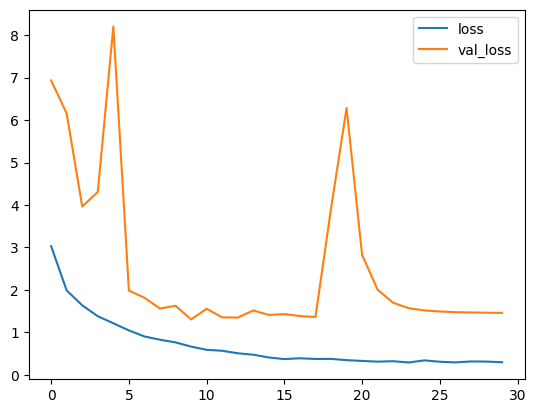

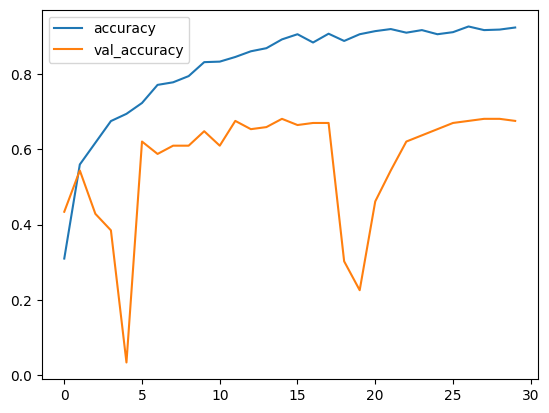

In [46]:
###########
# Fit Baseline Model
###########

#with strategy.scope():
history = model.fit(X_train_baseline, y_train_baseline, 
                    validation_data = (X_test_baseline, y_test_baseline),
                    batch_size = 32,
                    epochs = 30,
                    verbose = 1,
                    callbacks = [lr, myCallback()])



#X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline
# Print accuracy loss for train and val for Baseline
print("Baseline Model Loss and Accuracy for Training and Validation")
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
#history_df.loc[:,['auc','val_auc']].plot()
plt.show()

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.3880 - loss: 2.4382 - val_accuracy: 0.1575 - val_loss: 7.9643 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7087 - loss: 1.0818 - val_accuracy: 0.3800 - val_loss: 2.4463 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8482 - loss: 0.5909 - val_accuracy: 0.8050 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9161 - loss: 0.3635 - val_accuracy: 0.6350 - val_loss: 1.3042 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9385 - loss: 0.2382 - val_accuracy: 0.8600 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9714 - loss: 0.1342 - val_accuracy: 0.6025 - val_loss: 1.2365 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9815 - loss: 0.0990 - val_a

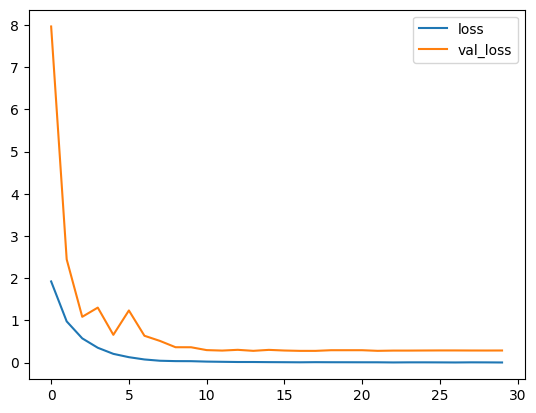

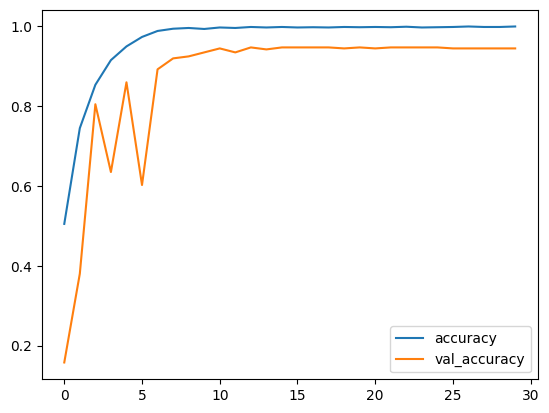

In [56]:
# Fitting Oversampled Model

#with strategy.scope():
history_over = model.fit(X_train_over, y_train_over, 
                    validation_data = (X_test_over, y_test_over),
                    batch_size = 32,
                    epochs = 30,
                    verbose = 1,
                    callbacks = [lr, myCallback()])

# Print accuracy loss for train and val for Baseline
print("Oversampled Model Loss and Accuracy for Training and Validation")
history_df_over = pd.DataFrame(history_over.history)
history_df_over.loc[:,['loss','val_loss']].plot()
history_df_over.loc[:,['accuracy','val_accuracy']].plot()
#history_df.loc[:,['auc','val_auc']].plot()
plt.show()

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.2043 - loss: 3.2845

I0000 00:00:1732245811.053439     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 20 bytes spill stores, 20 bytes spill loads



11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 726ms/step - accuracy: 0.2118 - loss: 3.2498 - val_accuracy: 0.0000e+00 - val_loss: 20.1367 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4777 - loss: 2.1389 - val_accuracy: 0.0000e+00 - val_loss: 15.8364 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5045 - loss: 1.8294 - val_accuracy: 0.0244 - val_loss: 9.2723 - learning_rate: 0.0010
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5271 - loss: 1.7982 - val_accuracy: 0.1098 - val_loss: 6.7726 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5245 - loss: 1.6781 - val_accuracy: 0.2073 - val_loss: 7.1128 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5280 - loss: 1.7054 - val_accuracy: 0.1829 - val_loss: 6.7177 - learning_rate: 0.0010
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5684 - loss: 1.5053 - val_ac

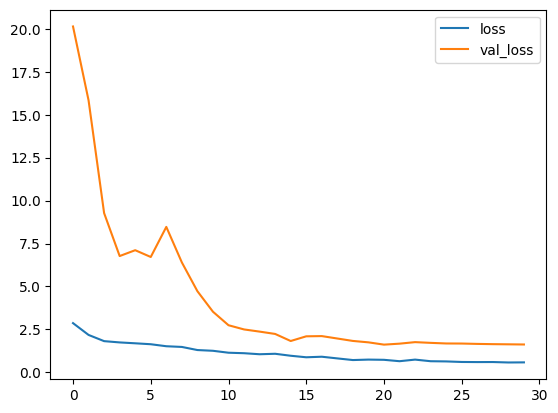

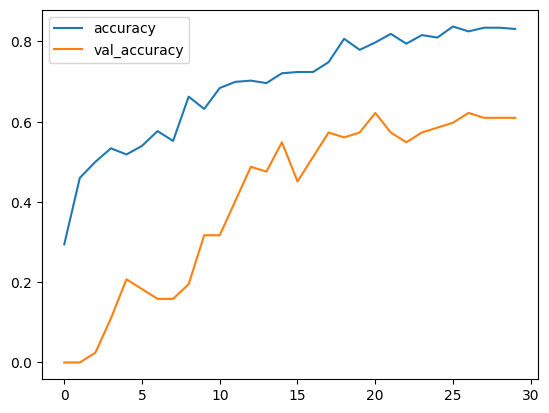

In [69]:
# Fitting Undersampled Model

#with strategy.scope():
history_under = model.fit(X_train_under, y_train_under, 
                    validation_data = (X_test_under, y_test_under),
                    batch_size = 32,
                    epochs = 30,
                    verbose = 1,
                    callbacks = [lr, myCallback()])

# Print accuracy loss for train and val for Baseline
print("Undersampled Model Loss and Accuracy for Training and Validation")
history_df_under = pd.DataFrame(history_under.history)
history_df_under.loc[:,['loss','val_loss']].plot()
history_df_under.loc[:,['accuracy','val_accuracy']].plot()
#history_df.loc[:,['auc','val_auc']].plot()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Model Test   Accuracy:  0.945


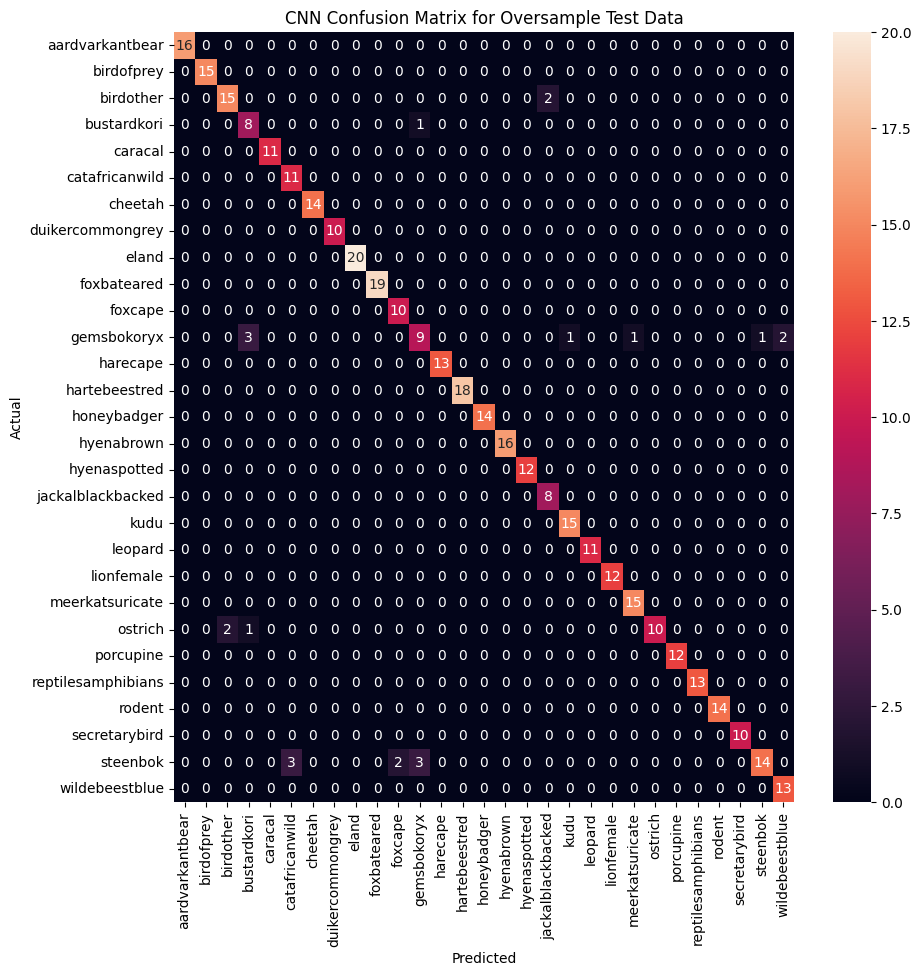

In [58]:
###########
### Confusion Matrix 
##########
#
# This section was ran for the Oversampled Model 
#
y_pred = model.predict(X_test_over)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test_over, axis=1)
acc = accuracy_score(y_val, y_pred)

#acc_list.append(acc)
print("Model Test   Accuracy: ", acc)

conf_mat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',

            xticklabels=np.unique(y_oversampled), yticklabels=np.unique(y_oversampled))

plt.title("CNN Confusion Matrix for Oversample Test Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=90)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Example Image Predictions


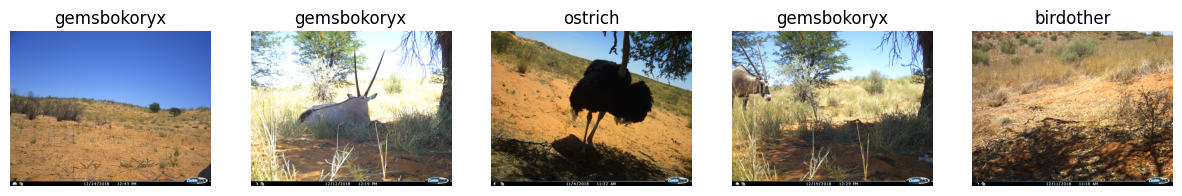

In [65]:
###########
### Predictions
##########
#
# This section was ran for the Oversampled Model 
#
y_p

examples = df['file'].sample(n=5)

x_examples = []

for i in examples:
    file_path = '/'.join([train_path, i[0]])
    img = cv2.imread(file_path)
    img = cv2.resize(img,(0, 0), fx = 0.1, fy = 0.1)
    img = (tf.cast(img, tf.float32) / 129.5) - 1
    x_examples.append(img)
x_examples = np.array(x_examples) 

   
prediction = model.predict(x_examples)
predicted_labels = np.argmax(prediction, axis=1)

classes = np.unique(y_oversampled)
pred_class = classes[predicted_labels]  

j=0

print("Example Image Predictions")
plt.figure(figsize=(15, 15))
for i, img in enumerate(examples):
    plt.subplot(1, 5, i+1)
    plt.title(pred_class[i])
    file_path = '/'.join([train_path, img[0]]) 
    img = np.array(Image.open(file_path))
    plt.imshow(img)
    plt.axis('off')
plt.show()



# Hyperparameter Tuning

In [49]:
#print("HYPER PARAMETER TUNING EPOCH 40")
#history = model.fit(X_train_baseline, y_train_baseline, 
#                    validation_data = (X_test_baseline, y_test_baseline),
#                    batch_size = 32,
#                    epochs = 40,
#                    verbose = 1,
#                    callbacks = [lr, myCallback()])
#print("HYPER PARAMETER TUNING EPOCH 50")
#history = model.fit(X_train_baseline, y_train_baseline, 
#                    validation_data = (X_test_baseline, y_test_baseline),
#                    batch_size = 32,
#                    epochs = 50,
#                    verbose = 1,
#                    callbacks = [lr, myCallback()])
#print("HYPER PARAMETER TUNING BATCH SIZE 64")
#history = model.fit(X_train_baseline, y_train_baseline, 
#                    validation_data = (X_test_baseline, y_test_baseline),
#                    batch_size = 64,
#                    epochs = 30,
#                    verbose = 1,
#                    callbacks = [lr, myCallback()])
#print("HYPER PARAMETER TUNING EPOCH 128")
#history = model.fit(X_train_baseline, y_train_baseline, 
#                    validation_data = (X_test_baseline, y_test_baseline),
#                    batch_size = 128,
#                    epochs = 30,
#                    verbose = 1,
#                    callbacks = [lr, myCallback()])




## Results and Analysis

The table below summarizes the validation results obtained for the different models:

|Model |	Accuracy|
|:---------|:-------------|
|Baseline 	| 0.6978 |
|Oversampled |	0.945 |
|Undersampled |	0.6098 |

The oversampled model performed very well compared to the other models and converged to a value close to 95% in about 10 epochs. Above I plotted the confusion matrix for the oversampled model and its performance can be visualized. A few examples of misclassifications were the steenbok and common gray duiker and the gemsbok oryx (gazelle) and black-backed jackal (dog).   

I tested hyperparameter tuning to try to improve the baseline model. In my initial investigation I experimented with increasing image input size, however that slowed the model down and didn't impact accuracy. For the hyperparameter tuning I tested changing epoch number and batch size. Below are the results for the validation data:

|Epoch |	Accuracy|
|:---------|:-------------|
|30 	| 0.6758 |
|40 |	0.6868 |
|50 |	0.6868 |

|Batch Size |	Accuracy|
|:---------|:-------------|
|30 	| 0.6758 |
|40 |	0.6923 |
|50 |	0.6923 |

Changing the hyperparameters did not help the improve the baseline model's accuracy. Increasing the batch size did decrease the time it took for the model to converge.

## Conclusion

This project has been a fun way to conclude the Machine Learning Series. In this project I used CNN models to classify wildlife camera images from the Kgalagadi Park. An initial problem I ran into was with the animal class distribution being imbalanced. Solving this by using an oversampling strategy worked well and achieved 95% accuracy. This project shows how advanced deep learning algorithms could contribute to wildlife conservation efforts and animal population dynamics research.

Some future work on the project could be to explore using different sampling algorithms. In my research I learned about the synthetic minority oversampling technique that creates new samples in minority classes. Another thing to explore would be combining data from other areas in the Snapshot Safari project. The data for this project was fairly small and having larger datasets could lead to better results as well as potentially add more animals to the classification task.  

## References
Lion, M. (2019, December 29). Snapshot Kgalagadi. LILA BC. https://lila.science/datasets/snapshot-kgalagadi

Miao, Z., Gaynor, K.M., Wang, J. et al. Insights and approaches using deep learning to classify wildlife. Sci Rep 9, 8137 (2019). https://doi.org/10.1038/s41598-019-44565-w

Miao, Z., Liu, Z., Gaynor, K.M. et al. Iterative human and automated identification of wildlife images. Nat Mach Intell 3, 885–895 (2021). https://doi.org/10.1038/s42256-021-00393-0